# Brain Solver Python Interference Notebook

This notebook utilizes the custom `brain_solver` package for analyzing brain activity data. Our data sources include official datasets from Kaggle competitions and additional datasets for enhanced model training and evaluation.

This is the Inference notebook.

## Data Sources

### Official:

- **HMS - Harmful Brain Activity Classification**
  - **Source:** [Kaggle Competition](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification)
  - **Description:** This competition focuses on classifying harmful brain activity. It includes a comprehensive dataset for training and testing models.

- **Brain-Spectrograms**
  - **Source:** [Kaggle Dataset](https://www.kaggle.com/datasets/cdeotte/brain-spectrograms)
  - **Description:** The `specs.npy` file contains all the spectrograms from the HMS competition, offering a detailed view of brain activity through visual representations.

### Additional:

- **Brain-EEG-Spectrograms**
  - **Source:** [Kaggle Dataset](https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms)
  - **Description:** The `EEG_Spectrograms` folder includes one NumPy file per EEG ID, with each array shaped as (128x256x4), representing (frequency, time, montage chain). This dataset provides a more nuanced understanding of brain activity through EEG spectrograms.

- **hms_efficientnetb0_pt_ckpts**
  - **Source:** [Kaggle Dataset](https://www.kaggle.com/datasets/crackle/hms-efficientnetb0-pt-ckpts)
  - **Description:** This dataset offers pre-trained checkpoints for EfficientNetB0 models, tailored for the HMS competition. It's intended for use in fine-tuning models on the specific task of harmful brain activity classification.


In [1]:
# !pip install d2l --no-index --find-links=file:///kaggle/input/d2l-package/d2l/
# !pip install /kaggle/input/brain-solver/brain_solver-0.9.0-py3-none-any.whl

In [1]:
import os, sys
import gc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from brain_solver import Helpers as hp, BrainModel as br, EEGDataset, Network, Trainer as tr

# Suppress warnings if desired
import warnings

warnings.filterwarnings("ignore")

# Setup for CUDA device selection
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Config Class Summary

The `Config` class manages configurations for a brain activity classification project. It includes:

- **Data and Model Paths**: Centralizes paths for data (e.g., EEG, spectrograms) and model checkpoints.
- **Training Parameters**: Configures training details like epochs, batch size, and learning rate.
- **Feature Flags**: Toggles for using wavelets, spectrograms, and reading options.

Designed for easy adjustments to facilitate model development and experimentation.


In [2]:
from brain_solver import Config
full_path = "/home/osloup/NoodleNappers/brain/data/"
full_path = "C:/Users/tygof/Documents/Semester 8/MLiP/NoodleNappers/brain/data/"
config = Config(full_path,  full_path + "out/", USE_EEG_SPECTROGRAMS=True, USE_KAGGLE_SPECTROGRAMS=True, should_read_brain_spectograms=False, should_read_eeg_spectrogram_files=False, USE_PRETRAINED_MODEL=False)

# full_path = "/kaggle/input/"
# config = Config(full_path, "/kaggle/working/", USE_EEG_SPECTROGRAMS=True, USE_KAGGLE_SPECTROGRAMS=True, should_read_brain_spectograms=False, should_read_eeg_spectrogram_files=False, USE_PRETRAINED_MODEL=False)

import sys
sys.path.append(full_path + 'kaggle-kl-div')
from kaggle_kl_div import score

In [3]:
# Create Output folder if does not exist
if not os.path.exists(config.output_path):
    os.makedirs(config.output_path)

# Initialize random environment
pl.seed_everything(config.seed, workers=True)

Seed set to 2024


2024

In [4]:
train_df: pd.DataFrame = hp.load_csv(config.data_train_csv)

if train_df is None:
    print("Failed to load the CSV file.")
    exit()
else:
    EEG_IDS = train_df.eeg_id.unique()
    TARGETS = train_df.columns[-6:]
    TARS = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
    TARS_INV = {x: y for y, x in TARS.items()}
    print("Train shape:", train_df.shape)

Train shape: (106800, 15)


In [5]:
test_df = pd.read_csv(config.data_test_csv)
print("Test shape", test_df.shape)
test_df.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


## Unprocessed

In [6]:
spectrograms2 = hp.read_spectrograms(
    path=config.data_spectograms_test,
    data_path_train_on_brain_spectograms_dataset_specs=None,
    read_files=True,
)

# Continue with renaming for DataLoader
test_df = test_df.rename({"spectrogram_id": "spec_id"}, axis=1)

There are 1 spectrogram parquets
0 , 

Converting Test EEG to Spectrograms...



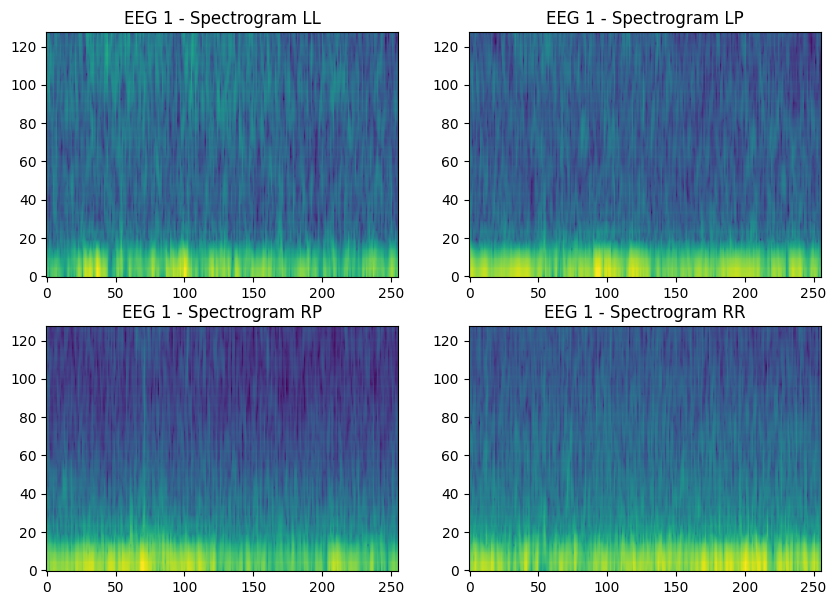

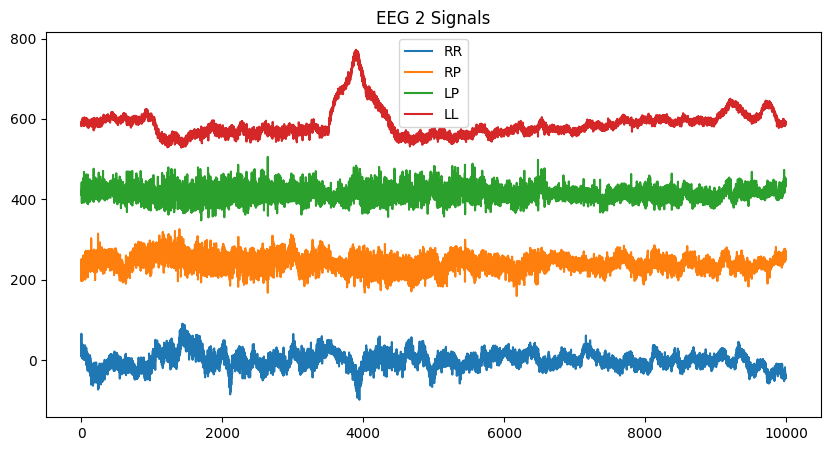


#########################



In [7]:
# READ ALL EEG SPECTROGRAMS
DISPLAY = 1
EEG_IDS2 = test_df.eeg_id.unique()
all_eegs2 = {}

print("Converting Test EEG to Spectrograms...")
print()
for i, eeg_id in enumerate(EEG_IDS2):

    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = hp.spectrogram_from_eeg(
        f"{config.data_eeg_test}{eeg_id}.parquet", i < DISPLAY, config.use_wavelet
    )
    all_eegs2[eeg_id] = img

In [9]:
# INFER EFFICIENTNET ON TEST
preds = []
test_ds = EEGDataset(
    test_df, specs=spectrograms2, eeg_specs=all_eegs2, targets=TARGETS, mode="test"
)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=64, num_workers=3)

for i in range(5):
    print("#" * 25)
    print(f"### Testing Fold {i+1}")

    ckpt_file = (
        f"EffNet_version{config.VER}_fold{i+1}.pth"
        if config.trained_model_path is None or config.FINE_TUNE
        else f"{config.trained_model_path}/EffNet_v{config.VER}_f{i}.ckpt"
    )

    if config.trained_model_path is None or config.FINE_TUNE:
        model = torch.load(config.full_path + "trained-model-effnet-mlip9/" + ckpt_file)
    else:
        model = tr.load_from_checkpoint(
        ckpt_file, weight_file=config.trained_weight_file,  use_kaggle_spectrograms=config.USE_KAGGLE_SPECTROGRAMS, use_eeg_spectrograms=config.USE_EEG_SPECTROGRAMS
    )
    model = model.to(device).eval()
    fold_preds = []

    with torch.inference_mode():
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            pred = torch.softmax(model(test_batch), dim=1).cpu().numpy()
            fold_preds.append(pred)

            # Delete variables not needed to free up memory
            del test_batch, pred
            gc.collect()  # Manually collect garbage

            if device.type == "cuda":  # Optionally clear CUDA cache if using GPU
                torch.cuda.empty_cache()

        fold_preds = np.concatenate(fold_preds)

    preds.append(fold_preds)

    del model
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()


pred = np.mean(preds, axis=0)
print()
print("Test preds shape", pred.shape)

#########################
### Testing Fold 1
#########################
### Testing Fold 2
#########################
### Testing Fold 3
#########################
### Testing Fold 4
#########################
### Testing Fold 5

Test preds shape (1, 6)


In [10]:
pred[0][2]

0.00067076966

In [11]:
sub = pd.DataFrame({"eeg_id": test_df.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv("submission.csv", index=False)
print("Submissionn shape", sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.24288,0.045547,0.000671,0.304879,0.044806,0.361217


In [12]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:, -6:].sum(axis=1)

0    1.0
dtype: float32